# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.
##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.
##### (6) 2007년과 2008년 데이터를 예측하여라

In [1]:
#collapse
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2)
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ────────────────────────────────────────────── fpp2 2.4 ──

✔ ggplot2   3.3.5     ✔ fma       2.4  
✔ forecast  8.15      ✔ expsmooth 2.3  

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”



Attaching package: ‘astsa’


The following objects are masked from ‘package:fma’:

    chicken, sales


The following object is masked from ‘package:forecast’:

    gas


The following object is masked from ‘package:fpp2’:

    oil


Loading required package: parallel

Loading required package: timeDate

Loading required package: timeSeries

Loading required package: fBasics


Attaching package: ‘fBasics’


The following object is masked from ‘package:astsa’:

    nyse


Loading required package: stats4


Attaching package: ‘sarima’


The following object is masked from ‘package:astsa’:

    sarima


Loading required package: zoo

Warning message:
“package ‘

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [64]:
#collapse
z <- as.numeric(mcopper)

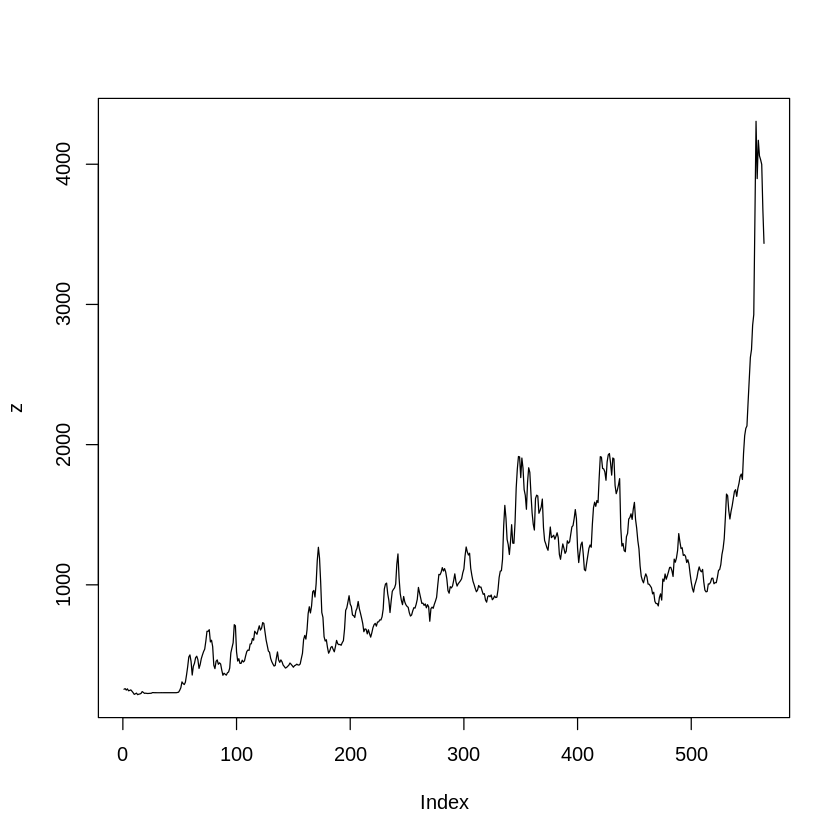

In [65]:
#collapse
plot(z, type='l')

- 등분산을 이루지 않고 있는 모습을 보인다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

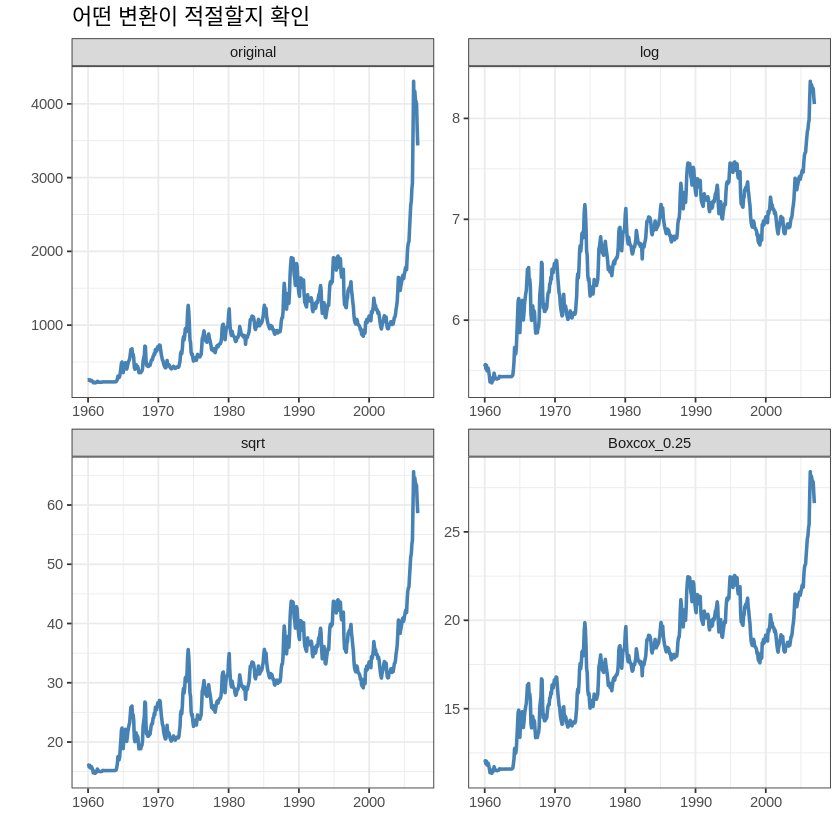

In [66]:
#collapse
tmp.dat <- data.table(
  t=seq.Date(as.Date("1960-01-01"), 
             by='month', 
             length.out=564),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.25 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("어떤 변환이 적절할지 확인")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

In [67]:
tmp.dat[, lnz:= log(z)]

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 적용했다.

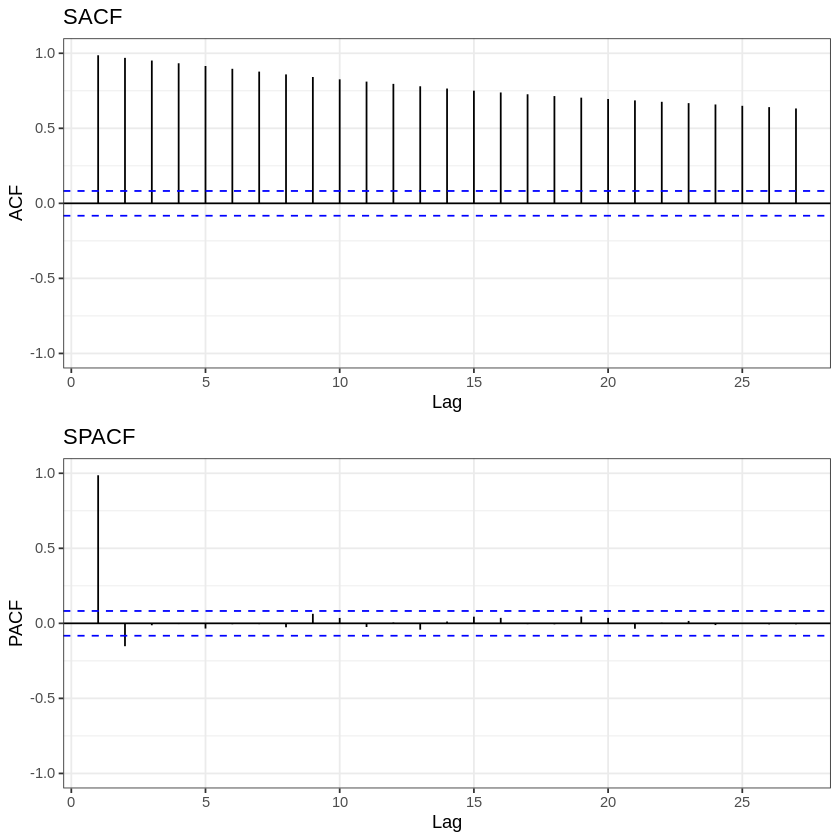

In [68]:
#collapse
p2 <- ggAcf(tmp.dat$lnz) + theme_bw() + ylim(-1,1) +  ggtitle("SACF")
p3 <- ggPacf(tmp.dat$lnz) + theme_bw() + ylim(-1,1) +  ggtitle("SPACF")

grid.arrange(p2, p3, nrow = 2, layout_matrix = rbind(c(0, 0), c(1, 1)))

- 또한 ACF가 지수적으로 천천히 감소하는 모양을 보여 추후 차분도 필요하다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [69]:
auto.arima(tmp.dat$lnz)
auto.arima(tmp.dat$lnz, trace=T, ic='aic')

Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -1555.199
 ARIMA(0,1,0) with drift         : -1485.363
 ARIMA(1,1,0) with drift         : -1543.596
 ARIMA(0,1,1) with drift         : -1556.04
 ARIMA(0,1,0)                    : -1484.453
 ARIMA(1,1,1) with drift         : -1553.325
 ARIMA(0,1,2) with drift         : -1554.063
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,1)                    : -1556.275
 ARIMA(1,1,1)                    : -1553.645
 ARIMA(0,1,2)                    : -1554.28
 ARIMA(1,1,0)                    : -1544.171
 ARIMA(1,1,2)                    : -1555.619

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,1)                    : -1561.685

 Best model: ARIMA(0,1,1)                    



Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- ARIMA(0.1.1) 모형, 즉 한 번 차분한 MA(1) 모형이 제일 적합하다는 결론이 나왔다.

In [70]:
fit = arima(tmp.dat$lnz, order = c(0,1,1))
fit


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

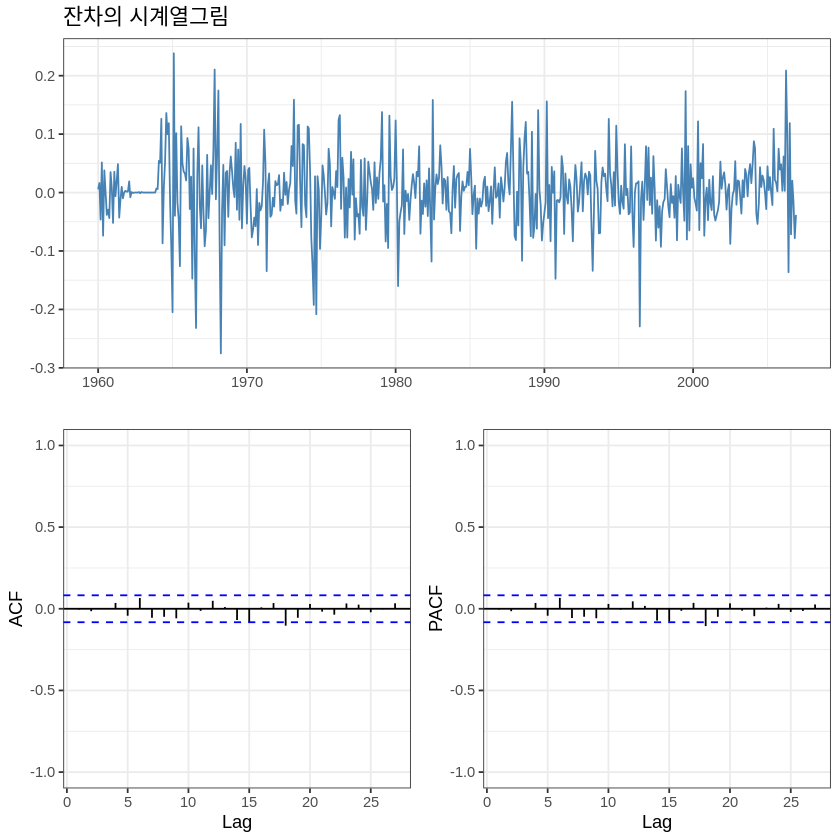

In [71]:
#collapse
tmp.dat[, res := as.numeric(resid(fit))]

p3 <- ggplot(tmp.dat, aes(t, res)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+
  theme_bw()

p1 <- ggAcf(tmp.dat$res) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(tmp.dat$res) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

,lags,statistic,df,p-value
,6,4.389073,5,0.49486084
,12,11.774747,11,0.38081082
,18,25.513977,17,0.08378234
,24,29.716259,23,0.15772145



	Shapiro-Wilk normality test

data:  tmp.dat$res
W = 0.96372, p-value = 1.406e-10


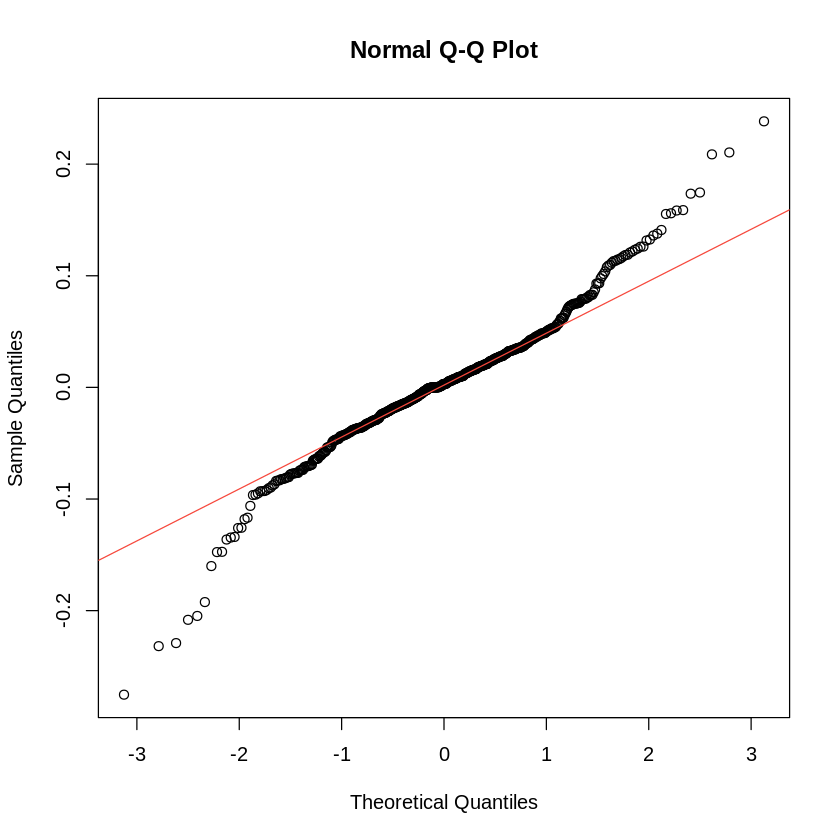

In [72]:
#collapse
LjungBox(fit, lags=seq(6,24,6))
shapiro.test(tmp.dat$res) 
qqnorm(tmp.dat$res)
qqline(tmp.dat$res, col = 2)

- 해당 모형에 적합한 후 잔차 그림을 그려보니 ACF,PACF에서 유의한 값을 찾을 수 없었고, 잔차그림도 잘 분산되어 있는 것 같다.
- 잔차의 포트맨토검정결과 모두 귀무가설을 기각하지 못해 모형 적합이 잘되었나 싶었지만, shapiro.test 결과 정규성가정을 만족하지 못했다.

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [79]:
tmp.dat[, diff_z := c(0, diff(lnz))]

- (1)의 결과로 차분이 필요하여 차분하였다.

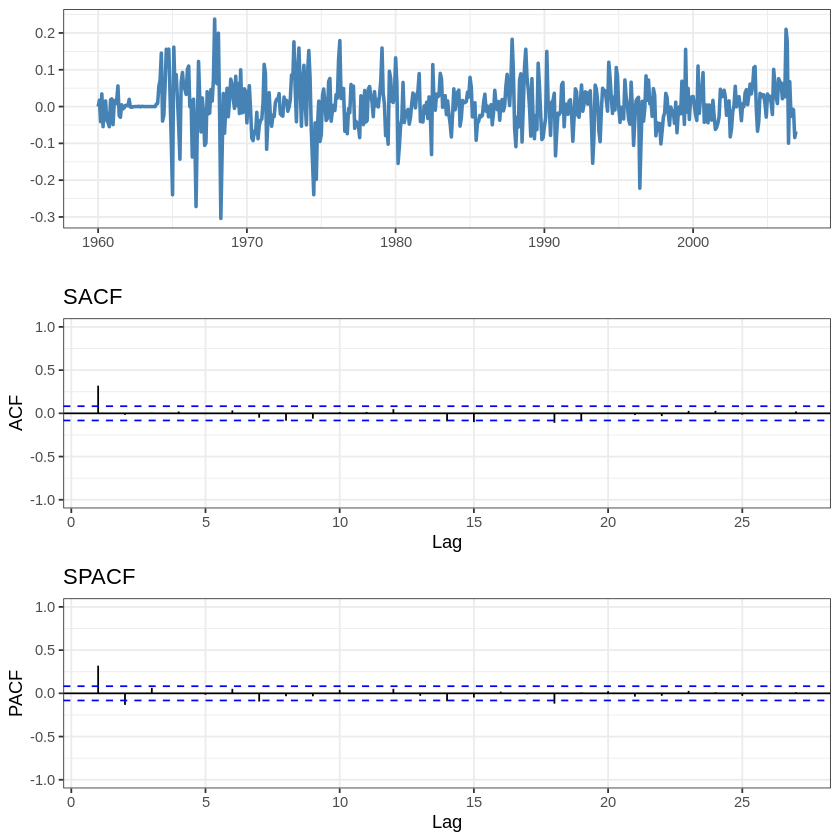

In [90]:
#collapse
p1 <- ggplot(tmp.dat, aes(t, diff_z)) + geom_line(col='steelblue', lwd=1) + xlab("")+ylab("")+
  theme_bw()
p2 <- ggAcf(tmp.dat[,diff_z]) + theme_bw() + ylim(-1,1) + ggtitle("SACF")
p3 <- ggPacf(tmp.dat[,diff_z ]) + theme_bw() +ylim(-1,1) + ggtitle("SPACF")
grid.arrange(p1,p2, p3, nrow = 3)

- 차분한 결과의 ACF, PACF 를 그려보았다.
- MA(1)모형 또는 AR(1) 모형이 적절해보인다.
- (2)에서 MA(1)모형을 적합해 보았으므로, AR(1) 모형을 선택했다.

- 분산 안정화 하고 보니 계절성분이 존재하는 것 같다.
- 또한 ACF 가 지수적으로 감소하는 형태를 볼 수 있었다.
- 하지만 ACF에서 계절 주기가 보이지 않아 계절차분은 필요없어 보인다.

In [46]:
## 단위근검정 H0 : phi=1
adfTest(dt$lnz, lags = 0, type = "c")
adfTest(dt$lnz, lags = 1, type = "c")
adfTest(dt$lnz, lags = 2, type = "c")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -0.9274
  P VALUE:
    0.7141 

Description:
 Thu Dec  9 21:21:25 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -1.5322
  P VALUE:
    0.488 

Description:
 Thu Dec  9 21:21:25 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -1.3283
  P VALUE:
    0.5642 

Description:
 Thu Dec  9 21:21:25 2021 by user: 


- 모두 귀무가설을 기각하지 못하여 단위근이 있다는 결론이 나온다.
- 단위근 있으니 차분을 해볼 것이다.

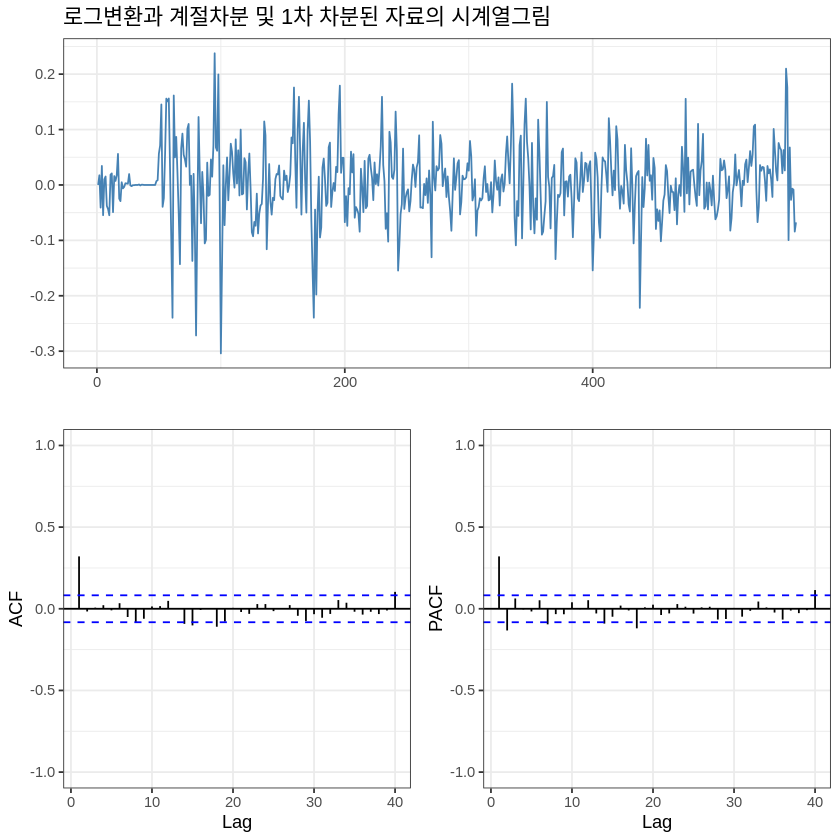

In [51]:
dt[, dt1_lnz := c(0, diff(lnz))]
dt1 <- dt[-1,]

p3 <- ggplot(dt, aes(t, dt1_lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환과 계절차분 및 1차 차분된 자료의 시계열그림')+
  theme_bw()

p1 <- ggAcf(dt$dt1_lnz, lag.max = 40) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$dt1_lnz, lag.max = 40) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

- 더이상 차분할 필요가 없겠다. 천천히 감소하거나 그런 그림이 보이지 않기 때문이다.
- ACF랑 pacf 둘 다 첫 번째 차수에서 유의한 모습이지만, PACF의 두 번째 차수는 애매하다.
- ACF를 보면 AR(1)인 것 같다.
- PACF를 보면 MA(1)이나 MA(2)인 거 같은데, MA(1)를 잠정모형으로 택해볼 것이다.

In [ ]:

하지만 잔차에 대한 검정을 했을때 문제가 없는 게 중요 그래서 앞에 거 선택하면 좋겠지?